Modelo de clasificación de imágenes con Data Augmentation
=========================================================

<div class="admonition warning">PRECAUCIÓN 😱: El tema presentado en esta sección está clasificado como avanzado. El entendimiento de este contenido es totalmente opcional.</div>

## Introducción

Como análistas o científicos de datos, en general una gran cantidad del tiempo que se invierte en el desarrollo de un modelo de aprendizaje automático está dedicado a la preparación, limpieza y reorganización de los datos. Los sistemas de visión por computadora no son la excepción.

Dependiendo del problema que estamos intentando resolver, será el tipo de preprocesamiento a realizar. Entre la tareas más comunes están:

Estandarización:

- Ajuste del tamaño de la imágen a un tamaño estandard.

- Recorte de las imágenes.

- Ajuste de colores (escala de grises, reducción de contraste, saturación).

- Transformaciones específicas como reducciones de ruido.

Aumento o augmentation del conjunto de datos:

- Rotaciones.

- Translaciones.

- Escalamiento.

- Modificacione de colores (escala de grises, HUE, saturación, brillo).

- Filtros específicos (borronear, ruido).

- Combinar imagenes o recortarlas.



### Preparación del ambiente

Intalamos las librerias necesarias

In [2]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/vision/tasks/classification/code/cnn_class.txt \
    --quiet --no-clobber
!pip install -r cnn_class.txt --quiet

### Sobre el conjunto de datos de este ejemplo

Para ejemplificar esta técnica utilizaremos un conjunto de datos muy popular llamado CIFAR-10. CIFAR-10 es un conjunto de datos que consiste en 60.000 imagenes a color de 32x32 agrupadas en 10 clases, con 6000 imagenes cada una. Hay alrededor de 50000 imagenes para entrenamiento y 10000 para testing.

Las categorias son:
 - airplane
 - automobile
 - bird
 - cat
 - deer
 - dog
 - frog
 - horse
 - ship
 - truck

Podemos cargar este conjunto de datos facilmente utilizando `tensorflow-datasets`:

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

ds, info = tfds.load('cifar10', split='train', shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete8HYSX7/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete8HYSX7/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
print("Numero de clases: ", info.features["label"].num_classes)
print("Clases disponibles: ", info.features["label"].names)

Numero de clases:  10
Clases disponibles:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Veamos algunos ejemplos:

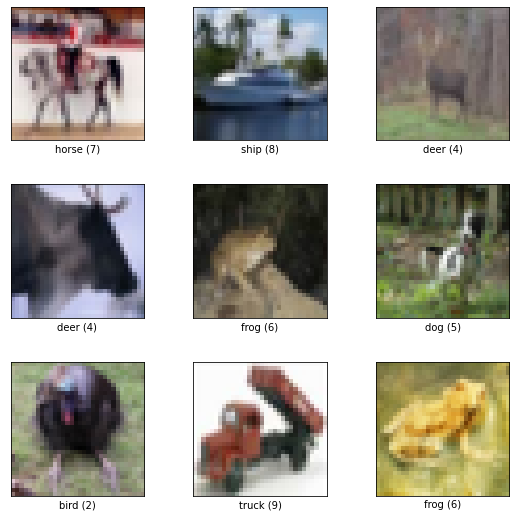

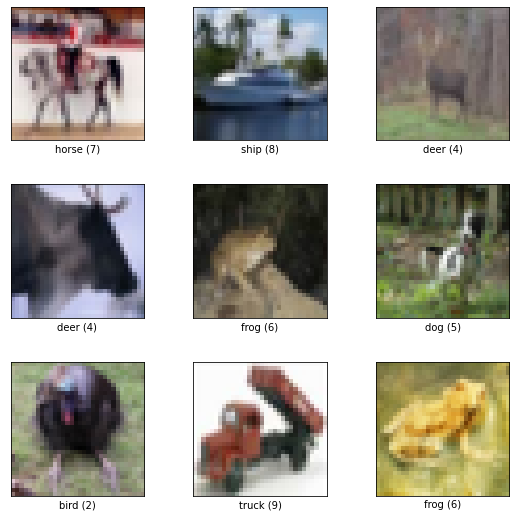

In [5]:
tfds.show_examples(ds, info)

## Construcción de una red neuronal convolucional

Antes de comenzar necesitaremos verificar que tenemos el runtime correcto en nuestro ambiente. Esta tarea se beneficiará mucho de una GPU.

In [6]:
import tensorflow as tf
print("GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPUs disponibles:  1


### Especificando las transformaciones de aumento de datos a realizar

En este primer intento haremos las siguientes transformaciones:

- Rotar horizontalmente la imagen
- Rotar la imagen de forma aleatoria con una probabilidad de 0.1
- Agrandar (zoom) la imagen de forma aleatroia con una probabilidad de 0.1

Para todas estas tareas `keras` dispone de una capa que nos permite realizar esto automáticamente:

In [11]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal", input_shape=(32, 32, 3)),
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(0.1),
    ]
)

Algunas cosas a notar:

- Note como pudimos empaquetar todas las transformaciones como un modelo secuencial.
- Note como `input_shape` solo aparece en la primera transformación que aplicamos. Esto se debe a que el mismo debe ser especificado en la primera capa de la red secuencial.

### Aplicando data augmentation a una arquitectura CNN estandar

In [12]:
def buildModel():
    model = keras.models.Sequential(layers=
      [
        data_augmentation,
        keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', ),
        keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
      ])
    

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

Instanciamos nuestro modelo y verificamos su arquitectura

In [13]:
model = buildModel()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

Antes de comenzar el entrenamiento, configuraremos nuestro conjunto de datos para una tarea supervisada. Esto lo hacemos especificando el parametro *as_supervised=True* lo cual nos da la posibilidad de acceder a las anotaciones del conjunto de datos.

In [14]:
(training_set, validation_set) = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

Configuramos los parametros de entrenamiento:

In [15]:
BATCH_SIZE=64
EPOCHS = 3

training_set_batch = training_set.batch(batch_size=BATCH_SIZE).cache().repeat()
validation_set_batch = validation_set.batch(batch_size=BATCH_SIZE).cache().repeat()
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples

Comenzamos el entrenamiento

In [16]:
history = model.fit(training_set_batch, 
                    epochs=EPOCHS,
                    steps_per_epoch=train_size,
                    validation_data=validation_set_batch,
                    validation_steps=test_size)

Epoch 1/3
50000/50000 [==============================] - 597s 11ms/step - loss: 1.2633 - accuracy: 0.5600 - val_loss: 1.1100 - val_accuracy: 0.6278
Epoch 2/3
50000/50000 [==============================] - 557s 11ms/step - loss: 1.1140 - accuracy: 0.6154 - val_loss: 1.1587 - val_accuracy: 0.6220
Epoch 3/3
50000/50000 [==============================] - 558s 11ms/step - loss: 1.0796 - accuracy: 0.6291 - val_loss: 1.2239 - val_accuracy: 0.6159


> Dado que estamos utilizando un objeto de tipo `tf.Dataset` como argumento de `validation_data` de `Model.fit`, Keras no sabe por cuantos etapas hay que validar. Por este motivo el argumento `validation_steps` fue configurado.

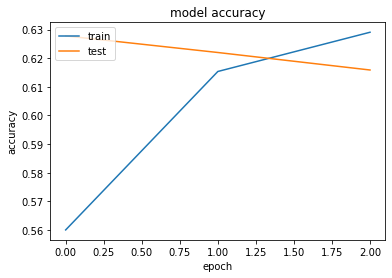

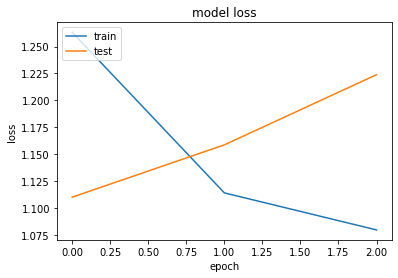

In [18]:
import matplotlib.pyplot as plt

def plot_history(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

plot_history(history)

> ¿Que le sugiere este gráfico? ¿Porque le parece que la técnica no dio resultados?